# ML Zoomcamp 2023 – Second Capstone Project

[Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs)

In [1]:
import os
import re
import subprocess
from pathlib import Path
from time import time
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
try:
    import skimage
    print('Module skimage is installed.')
except ImportError:
    print('Module skimage is not installed, installing it now with pip.')
    p1 = subprocess.run('python -m pip install scikit-image -q', shell=True,
                        check=True, capture_output=True, text=True)
    if p1.stderr:
          print(p1.stderr)
from skimage.io import imread
from skimage.transform import resize

Module skimage is installed.


In [61]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img

In [4]:
images_dir = Path.cwd() / 'data/raw/Images'
annotation_dir = Path.cwd() / 'data/raw/Annotation'
processed_dir = Path.cwd() / 'data/processed'

## Data preparation

In [5]:
# folder names come from namimg in raw/Images and raw/Annotation folders
breed_dir_list = ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound',
                  'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed',
                  'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees',
                  'n02111129-Leonberg']

In [7]:
# modified from https://www.kaggle.com/code/hengzheng/dog-breeds-classifier/notebook
if not processed_dir.exists():
    Path.mkdir(processed_dir, exist_ok=True)
    for breed_dir in breed_dir_list:
        breed_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', breed_dir)
        breed_name = re.sub(r'-', r'_', breed_name.lower())
        Path.mkdir(processed_dir / breed_name, exist_ok=True)
    print(f'''Created {len(os.listdir(processed_dir))} folders to store cropped images of the different breeds.''')
else:
    print(f'Folder {processed_dir} already exists.')

Created 10 folders to store cropped images of the different breeds.


In [9]:
t0 = time()
img_size = 299
print(f'Saving {img_size}x{img_size} image sizes.')
if not list(processed_dir.glob('**/*.jpg')):
    for breed_dir in breed_dir_list:
        counter = 0
        for breed_prefix in os.listdir(f'{annotation_dir}/{breed_dir}'):
            img = Image.open(f'{images_dir}/{breed_dir}/{breed_prefix}.jpg')
            tree = ET.parse(f'{annotation_dir}/{breed_dir}/{breed_prefix}')
            xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
            xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
            ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
            ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
            img = img.crop((xmin, ymin, xmax, ymax))
            img = img.convert('RGB')
            img = img.resize((img_size, img_size))
            breed_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', breed_dir)
            breed_name = re.sub(r'-', r'_', breed_name.lower())
            img.save(str(processed_dir) + '/' + breed_name + '/' + breed_prefix + '.jpg')
            counter += 1
        print(f'Saved {counter} images in {breed_name} folder.')
    print(f'Time elapsed: {round(time()-t0, 0)} seconds.')
else:
    print(f'Folder {str(processed_dir)} with cropped images already exists.')

Saving 299x299 image sizes.
Saved 252 images in maltese_dog folder.
Saved 239 images in afghan_hound folder.
Saved 232 images in scottish_deerhound folder.
Saved 219 images in pomeranian folder.
Saved 218 images in bernese_mountain_dog folder.
Saved 218 images in samoyed folder.
Saved 218 images in irish_wolfhound folder.
Saved 214 images in shih_tzu folder.
Saved 213 images in great_pyrenees folder.
Saved 210 images in leonberg folder.
Time elapsed: 9.0 seconds.


### Removal of corrupted images

In [62]:
num_skipped = 0
for folder_name in breed_dir_list:
    folder_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', str(folder_name))
    folder_name = re.sub(r'-', r'_', folder_name.lower())
    breed_dir = processed_dir / folder_name
    print(f'Looking into folder {str(breed_dir)}')
    for fname in os.listdir(breed_dir):
        fpath = breed_dir / fname
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print(f"Deleted {num_skipped} images.")

Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/maltese_dog
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/afghan_hound
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/scottish_deerhound
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/pomeranian
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/bernese_mountain_dog
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/samoyed
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/irish_wolfhound
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/shih_tzu
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/great_pyrenees
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/leonberg
Deleted

## Pre-trained convolutional neural networks

In [11]:
model = Xception(weights='imagenet', input_shape=(img_size, img_size, 3))

In [12]:
path_to_image = 'data/processed/scottish_deerhound/n02092002_109.jpg'
img = load_img(path_to_image, target_size=(img_size, img_size))
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)
pred = model.predict(X)
decode_predictions(pred)

1/1 [==============================] - 1s 1s/step


[[('n02092002', 'Scottish_deerhound', 0.7939882),
  ('n02090721', 'Irish_wolfhound', 0.04308395),
  ('n02090622', 'borzoi', 0.005164045),
  ('n02091244', 'Ibizan_hound', 0.0030015495),
  ('n02100236', 'German_short-haired_pointer', 0.0029592111)]]

## Data generation

In [63]:
new_img_size = 150
image_size_tuple = (new_img_size, new_img_size)
batch_size = 32

In [66]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    processed_dir,
    validation_split = 0.2,
    subset = 'both',
    seed = 33,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = image_size_tuple,
    batch_size = batch_size,
)

Found 2233 files belonging to 10 classes.
Using 1787 files for training.
Using 446 files for validation.


### Data visualization

In [67]:
names = train_ds.class_names

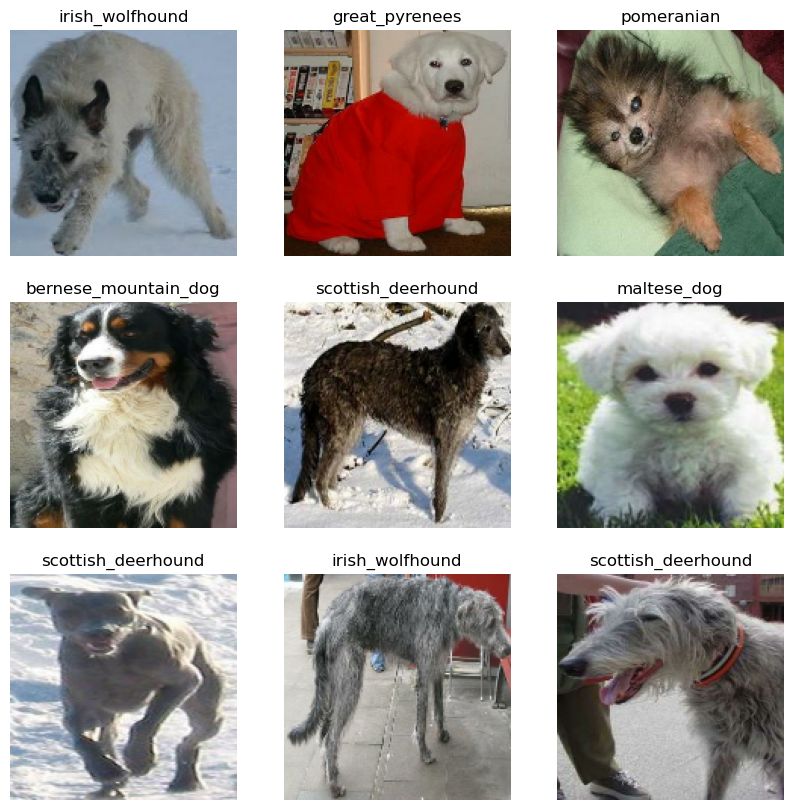

In [69]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype('uint8'))
        plt.title(names[list(labels[i]).index(1)])
        plt.axis('off')

## Transfer learning

Using a small image size to decrease training time.

In [55]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
base_model.trainable = False
inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)

In [56]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [19]:
history = model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
56/56 [==============================] - 49s 824ms/step - loss: 30.2813 - accuracy: 0.2501 - val_loss: 17.1394 - val_accuracy: 0.3161
Epoch 2/10
56/56 [==============================] - 45s 804ms/step - loss: 13.8778 - accuracy: 0.3637 - val_loss: 16.1909 - val_accuracy: 0.3475
Epoch 3/10
56/56 [==============================] - 45s 810ms/step - loss: 10.4882 - accuracy: 0.4264 - val_loss: 17.9481 - val_accuracy: 0.3610
Epoch 4/10
56/56 [==============================] - 45s 809ms/step - loss: 8.9844 - accuracy: 0.4745 - val_loss: 13.8138 - val_accuracy: 0.3700
Epoch 5/10
56/56 [==============================] - 45s 805ms/step - loss: 8.5780 - accuracy: 0.5025 - val_loss: 16.3376 - val_accuracy: 0.3408
Epoch 6/10
56/56 [==============================] - 45s 806ms/step - loss: 9.5243 - accuracy: 0.5204 - val_loss: 18.3655 - val_accuracy: 0.3744
Epoch 7/10
56/56 [==============================] - 45s 804ms/step - loss: 9.7020 - accuracy: 0.5104 - val_loss: 16.7165 - val_accura

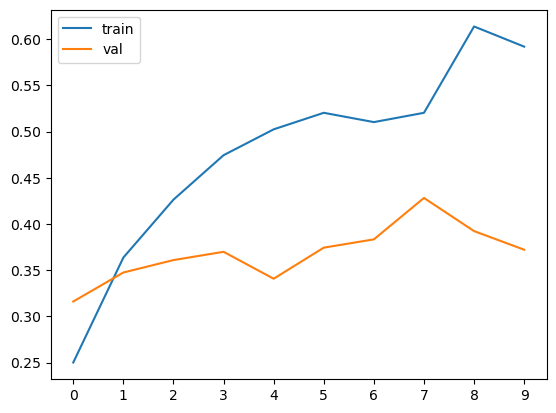

In [20]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## Data augmentation

In [84]:
data_augmentation_layers = [
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
]

In [71]:
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

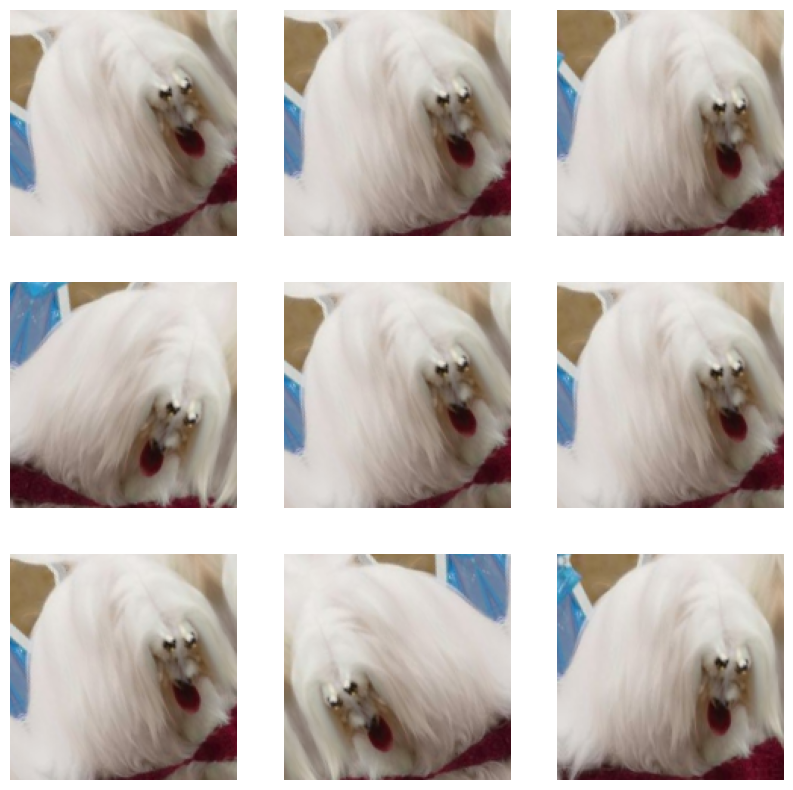

In [83]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [74]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
base_model.trainable = False
inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
augmented_inputs = data_augmentation(inputs)
scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
base = base_model(scaled_inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)

In [75]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [76]:
history = model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
56/56 [==============================] - 51s 856ms/step - loss: 0.8644 - accuracy: 0.8243 - val_loss: 0.4279 - val_accuracy: 0.9148
Epoch 2/10
56/56 [==============================] - 47s 843ms/step - loss: 0.5475 - accuracy: 0.8842 - val_loss: 0.5722 - val_accuracy: 0.9126
Epoch 3/10
56/56 [==============================] - 47s 841ms/step - loss: 0.6246 - accuracy: 0.8830 - val_loss: 0.7077 - val_accuracy: 0.9058
Epoch 4/10
56/56 [==============================] - 47s 835ms/step - loss: 0.5969 - accuracy: 0.8959 - val_loss: 0.6778 - val_accuracy: 0.8946
Epoch 5/10
56/56 [==============================] - 47s 834ms/step - loss: 0.6270 - accuracy: 0.8982 - val_loss: 0.8157 - val_accuracy: 0.8834
Epoch 6/10
56/56 [==============================] - 46s 830ms/step - loss: 0.4764 - accuracy: 0.9172 - val_loss: 0.4828 - val_accuracy: 0.9260
Epoch 7/10
56/56 [==============================] - 47s 835ms/step - loss: 0.2994 - accuracy: 0.9334 - val_loss: 0.6151 - val_accuracy: 0.9170

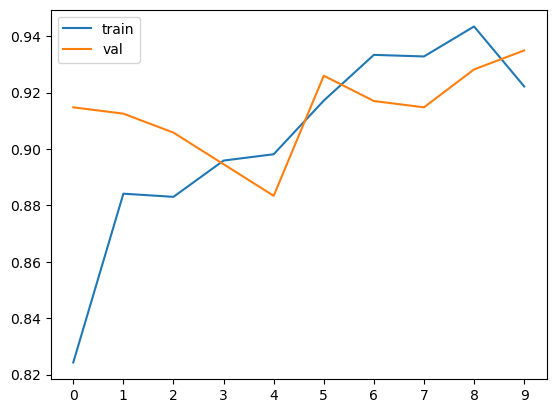

In [78]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## Tuning the learning rate

In [87]:
def make_model(learning_rate=0.01):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
    augmented_inputs = data_augmentation(inputs)
    scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
    base = base_model(scaled_inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    return model

In [88]:
learning_rate_scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(f'Learning rate: {lr}')
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    learning_rate_scores[lr] = history.history
    print()
    print('*****'*10)
    print()

Learning rate: 0.0001
Epoch 1/10
56/56 [==============================] - 50s 849ms/step - loss: 1.8191 - accuracy: 0.4029 - val_loss: 1.1261 - val_accuracy: 0.7422
Epoch 2/10
56/56 [==============================] - 47s 835ms/step - loss: 0.9658 - accuracy: 0.7734 - val_loss: 0.6097 - val_accuracy: 0.8789
Epoch 3/10
56/56 [==============================] - 47s 836ms/step - loss: 0.6490 - accuracy: 0.8422 - val_loss: 0.4273 - val_accuracy: 0.9013
Epoch 4/10
56/56 [==============================] - 46s 831ms/step - loss: 0.4820 - accuracy: 0.8735 - val_loss: 0.3434 - val_accuracy: 0.9081
Epoch 5/10
56/56 [==============================] - 47s 835ms/step - loss: 0.4355 - accuracy: 0.8836 - val_loss: 0.2977 - val_accuracy: 0.9148
Epoch 6/10
56/56 [==============================] - 47s 835ms/step - loss: 0.3877 - accuracy: 0.8892 - val_loss: 0.2688 - val_accuracy: 0.9215
Epoch 7/10
56/56 [==============================] - 47s 840ms/step - loss: 0.3536 - accuracy: 0.8965 - val_loss: 0.2513 

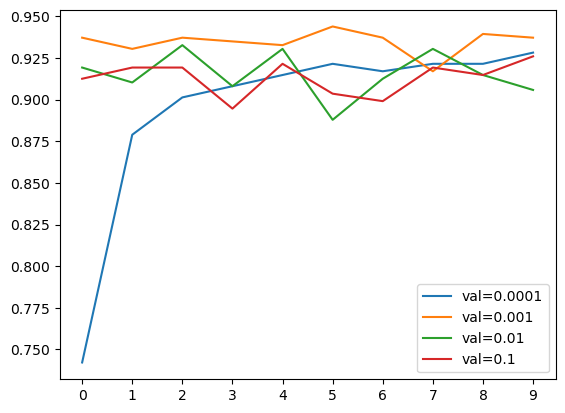

In [90]:
for lr, hist in learning_rate_scores.items():
    # plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))
plt.xticks(np.arange(10))
plt.legend()

## Adjusting inner layers

In [91]:
def make_model(learning_rate=0.01, size_inner=100):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
    augmented_inputs = data_augmentation(inputs)
    scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
    base = base_model(scaled_inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    outputs = keras.layers.Dense(10)(inner)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    return model

In [92]:
best_learning_rate = 0.001
size_scores = {}
for size in [10, 100, 1000]:
    print(f'Inner layer size: {size}')
    model = make_model(learning_rate=best_learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    size_scores[size] = history.history
    print()
    print('*****'*10)
    print()

Inner layer size: 10
Epoch 1/10
56/56 [==============================] - 51s 867ms/step - loss: 1.0946 - accuracy: 0.6060 - val_loss: 0.4209 - val_accuracy: 0.8408
Epoch 2/10
56/56 [==============================] - 47s 841ms/step - loss: 0.4342 - accuracy: 0.8640 - val_loss: 0.2213 - val_accuracy: 0.9439
Epoch 3/10
56/56 [==============================] - 47s 838ms/step - loss: 0.3133 - accuracy: 0.9015 - val_loss: 0.1882 - val_accuracy: 0.9417
Epoch 4/10
56/56 [==============================] - 47s 842ms/step - loss: 0.2648 - accuracy: 0.9155 - val_loss: 0.2052 - val_accuracy: 0.9170
Epoch 5/10
56/56 [==============================] - 47s 840ms/step - loss: 0.2707 - accuracy: 0.9065 - val_loss: 0.1925 - val_accuracy: 0.9350
Epoch 6/10
56/56 [==============================] - 47s 837ms/step - loss: 0.2364 - accuracy: 0.9082 - val_loss: 0.1694 - val_accuracy: 0.9395
Epoch 7/10
56/56 [==============================] - 47s 836ms/step - loss: 0.2331 - accuracy: 0.9222 - val_loss: 0.1971 -

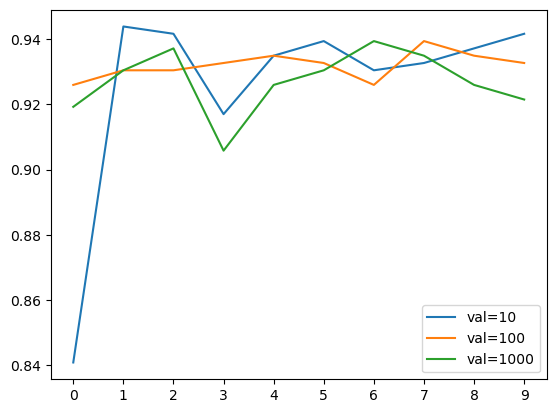

In [94]:
for size, hist in size_scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % size))
plt.xticks(np.arange(10))
plt.legend()

## Adding dropout

In [95]:
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
    augmented_inputs = data_augmentation(inputs)
    scaled_inputs = keras.layers.Rescaling(1./255)(augmented_inputs)
    base = base_model(scaled_inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    return model

In [96]:
best_learning_rate = 0.001
best_size = 10
droprate_scores = {}
for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(f'Dropout rate: {droprate}')
    model = make_model(learning_rate=best_learning_rate, size_inner=best_size, droprate=droprate)
    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    droprate_scores[droprate] = history.history
    print()
    print('*****'*10)
    print()

Dropout rate: 0.0
Epoch 1/30
56/56 [==============================] - 49s 838ms/step - loss: 1.2694 - accuracy: 0.5087 - val_loss: 0.5786 - val_accuracy: 0.8274
Epoch 2/30
56/56 [==============================] - 45s 812ms/step - loss: 0.5052 - accuracy: 0.8500 - val_loss: 0.3021 - val_accuracy: 0.9215
Epoch 3/30
56/56 [==============================] - 45s 811ms/step - loss: 0.3373 - accuracy: 0.8993 - val_loss: 0.2223 - val_accuracy: 0.9462
Epoch 4/30
56/56 [==============================] - 45s 811ms/step - loss: 0.2794 - accuracy: 0.9060 - val_loss: 0.2126 - val_accuracy: 0.9372
Epoch 5/30
56/56 [==============================] - 45s 811ms/step - loss: 0.2674 - accuracy: 0.9138 - val_loss: 0.1935 - val_accuracy: 0.9439
Epoch 6/30
56/56 [==============================] - 45s 808ms/step - loss: 0.2287 - accuracy: 0.9245 - val_loss: 0.1997 - val_accuracy: 0.9327
Epoch 7/30
56/56 [==============================] - 45s 811ms/step - loss: 0.2334 - accuracy: 0.9149 - val_loss: 0.2004 - va

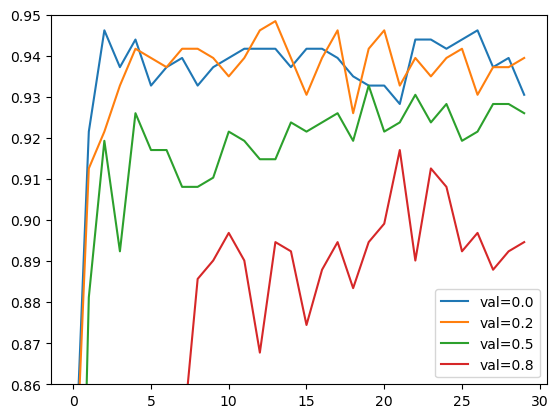

In [118]:
for droprate, hist in droprate_scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' % droprate))
plt.ylim(0.86, 0.95)
plt.legend(loc=4)

In [121]:
best_learning_rate = 0.001
best_size = 10
best_droprate = 0.2
model = make_model(learning_rate=best_learning_rate, size_inner=best_size, droprate=best_droprate)

In [122]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
56/56 [==============================] - 48s 808ms/step - loss: 1.4941 - accuracy: 0.4628 - val_loss: 0.7324 - val_accuracy: 0.7892
Epoch 2/50
56/56 [==============================] - 44s 790ms/step - loss: 0.9554 - accuracy: 0.6458 - val_loss: 0.4887 - val_accuracy: 0.8386
Epoch 3/50
56/56 [==============================] - 44s 790ms/step - loss: 0.8236 - accuracy: 0.7264 - val_loss: 0.3824 - val_accuracy: 0.9103
Epoch 4/50
56/56 [==============================] - 44s 792ms/step - loss: 0.7047 - accuracy: 0.7543 - val_loss: 0.3289 - val_accuracy: 0.9170
Epoch 5/50
56/56 [==============================] - 44s 792ms/step - loss: 0.6892 - accuracy: 0.7577 - val_loss: 0.2993 - val_accuracy: 0.9238
Epoch 6/50
56/56 [==============================] - 44s 792ms/step - loss: 0.6019 - accuracy: 0.7902 - val_loss: 0.2611 - val_accuracy: 0.9350
Epoch 7/50
56/56 [==============================] - 44s 794ms/step - loss: 0.6152 - accuracy: 0.7868 - val_loss: 0.2737 - val_accuracy: 0.9081

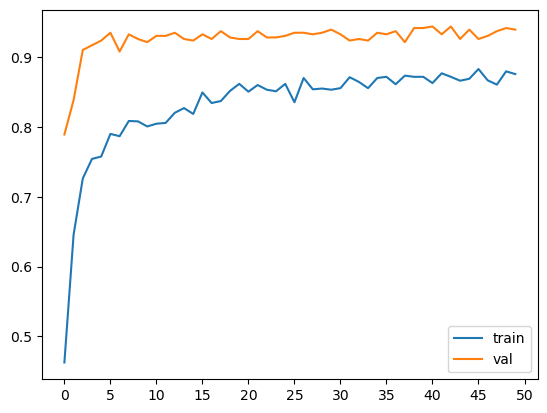

In [126]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.linspace(0, 50, 11))
plt.legend()